In [10]:
# ============================================
# FAKE NEWS DETECTION USING BERT (MANUAL LOOP)
# ============================================

!pip install transformers datasets torch tqdm scikit-learn -q

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd
import numpy as np


In [11]:
# ============================
# 1. LOAD & CLEAN DATA
# ============================
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [12]:
# xoá cột và điền giá trị thiếu bằng chuỗi dữ liệu trống
df = df.drop(columns=['Unnamed: 0'])
df = df.fillna('')
df.isnull().sum()

,0
title,0
text,0
label,0


In [13]:

df['text'] = df['title'].fillna('') + " " + df['text'].fillna('')


# chuẩn bị biến đầu vào và nhãn

In [14]:

# Đầu vào và nhãn
X = df["text"].tolist()
y = df["label"].astype(int).tolist()


# chia tập huấn luyện và kiểm thử

chia tập data thành 80 dữ liẹu để huấn luyện và 20% để kiểm thử

In [15]:

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# tokenization

In [16]:
# ============================
# 2. TOKENIZATION
# ============================
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

# xây dựng lớp dataset cho PyTorch
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
        }

# chia dữ liệu thành batch nhỏ, xáo trộn dữ liệu trong train để tránh mô hình học thuộc thứ tự
# Tạo dataset
train_dataset = FakeNewsDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = FakeNewsDataset(X_test, y_test, tokenizer, MAX_LEN)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [17]:

# ============================
# 3. MODEL & OPTIMIZER
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# định nghĩa mô hình
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
####1
# ============================
# 4. TRAINING LOOP
# ============================
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Average training loss: {avg_train_loss:.4f}")


Epoch 1 | Average training loss: 0.0504


Epoch 2 | Average training loss: 0.0155


Epoch 3 | Average training loss: 0.0084


In [19]:
# ============================
# 5. EVALUATION
# ============================
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


Evaluating: 100%|██████████| 902/902 [02:17<00:00,  6.55it/s]


In [20]:


# ============================
# 6. RESULTS
# ============================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))



Classification Report:
              precision    recall  f1-score   support

           0     0.9933    0.9931    0.9932      7006
           1     0.9935    0.9937    0.9936      7421

    accuracy                         0.9934     14427
   macro avg     0.9934    0.9934    0.9934     14427
weighted avg     0.9934    0.9934    0.9934     14427

Accuracy: 0.9934151244194912
Weighted F1: 0.993415111247541



Confusion Matrix:
[[6958   48]
 [  47 7374]]


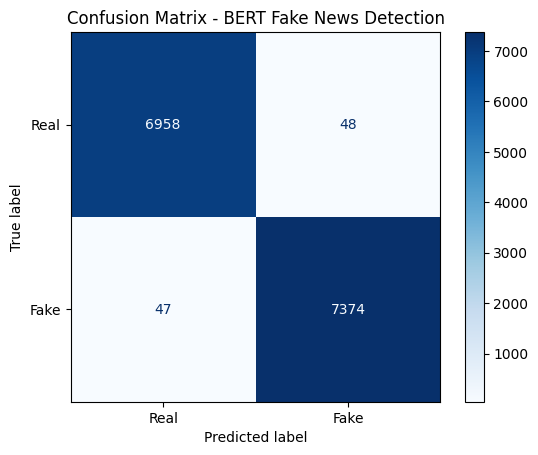

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)

# In ma trận ra console
print("\nConfusion Matrix:")
print(cm)

# Vẽ ma trận nhầm lẫn trực quan
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT Fake News Detection")
plt.show()


Trong bài toán phát hiện tin giả, điều quan trọng là:

- Phát hiện đúng tin giả (Recall cao cho lớp “Fake”) để không bỏ sót các bài báo sai lệch.

- Đồng thời, Precision cao giúp tránh việc gắn nhầm tin thật là tin giả (tránh false positive).

- → Cả hai mô hình đều có precision và recall đều rất cao (>95%), nhưng mô hình thứ hai có độ chính xác toàn cục (accuracy) và F1-weighted cao hơn khoảng 1.5%, cho thấy:

- Mô hình 2 học tốt hơn ranh giới giữa hai lớp.

- Dự đoán ổn định, giảm lỗi cả hai chiều (bỏ sót và nhầm lẫn).

- Cân bằng tốt hơn giữa hai loại rủi ro (False Positive và False Negative).

Sau khi huấn luyện và đánh giá, mô hình thứ hai đạt độ chính xác 99.33% và F1-score có trọng số 0.9933, cao hơn so với mô hình đầu tiên (97.81%).
Sự cải thiện này phản ánh khả năng phân biệt tốt hơn giữa tin thật và tin giả, đồng thời đảm bảo cân bằng giữa precision và recall ở cả hai lớp.
Với độ chính xác và F1 cao như vậy, mô hình BERT fine-tune được xem là đủ mạnh và đáng tin cậy trong bối cảnh phát hiện tin giả, đáp ứng yêu cầu thực tế triển khai.

# lưu model

In [22]:
# ============================
# 7. LƯU MODEL ĐÃ TRAIN XONG
# ============================

# Thư mục để lưu model
SAVE_DIR = "./bert-fake-news-detector"

# Tạo thư mục nếu chưa tồn tại
import os
os.makedirs(SAVE_DIR, exist_ok=True)

# Lưu toàn bộ model + tokenizer (cách được khuyến nghị nhất)
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"Model và tokenizer đã được lưu thành công vào thư mục: {SAVE_DIR}")

Model và tokenizer đã được lưu thành công vào thư mục: ./bert-fake-news-detector


# load lại hhi dùng không cần phải train lại

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load lại tokenizer và model
loaded_tokenizer = AutoTokenizer.from_pretrained("./bert-fake-news-detector")
loaded_model = AutoModelForSequenceClassification.from_pretrained("./bert-fake-news-detector")

# Đưa model lên GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
loaded_model.eval()

print("Load model thành công!")